In [3]:
import _init_paths
import caffe
caffe.set_mode_gpu()
caffe.set_device(0)

import os,cv2
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np

from data_layer.batch import get_minibatch
from utils.timer import Timer

timer = Timer()

# change configuration input size
from configuration.config import cfg
cfg.TEST.INPUT_SIZE = 224

In [4]:
# dataset directory
DATA_DIR = osp.join('..', 'data', 'GeneralCLS')

# load class labels and test roidb
from datafactory.load import load_images, load_sysnets
test_roidb = load_images(DATA_DIR, fname='test.txt')
class_labels, _ = load_sysnets(DATA_DIR)
#print class_labels
num_classes = len(class_labels)
print 'Number of classes: {}'.format(num_classes)

Number of classes: 62


In [5]:
# get test net
MODEL_DEF = osp.join('..','models', 'GeneralCLS', 'test_fc.prototxt')
#WEIGHTS = osp.join('..', 'out', 'GCLS_iter_800000.caffemodel')
WEIGHTS = osp.join('..', 'out', 'googlenet_home_GCLS_iter_300000.caffemodel')

net = caffe.Net(MODEL_DEF , WEIGHTS, caffe.TEST)


params = ['cls_score']
# fc_params = {name: (weights, biases)}
fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}

for fc in params:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

cls_score weights are (124, 1024) dimensional and biases are (124,) dimensional


In [6]:
# net surgery to convert fc to conv
MODEL_DEF_CONV = osp.join('..','models', 'GeneralCLS', 'test_conv.prototxt')

net_full_conv = caffe.Net(MODEL_DEF_CONV, WEIGHTS, caffe.TEST)

params_full_conv = ['cls_score_conv']
# conv_params = {name: (weights, biases)}
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}

for conv in params_full_conv:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)
    

for pr, pr_conv in zip(params, params_full_conv):
    conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
    conv_params[pr_conv][1][...] = fc_params[pr][1]

# save the FCN model
net_full_conv.save(osp.join('..', 'out', 'googlenet_home_GCLS_iter_800000_conv.caffemodel'))

cls_score_conv weights are (124, 1024, 1, 1) dimensional and biases are (124,) dimensional


In [7]:
print net_full_conv.blobs['cls_score'].data.shape

(1, 124, 1, 1)


In [8]:
def single_test(ind, isShow = False):
    label = test_roidb[ind]['label']
    #print label
    if isShow == True:
        im = cv2.imread(test_roidb[ind]['im_path']);im = im[:, :, (2, 1, 0)]
        plt.imshow(im);plt.show()
    #blob = get_minibatch([test_roidb[ind]], num_classes, 'TEST', pixel_means=np.array([[[  94.77118551,  121.64301872,  143.5132104 ]]]))
    blob = get_minibatch([test_roidb[ind]], num_classes, 'TEST')
    blob = {'data': blob['data']}
    
    net_full_conv.blobs['data'].reshape(*blob['data'].shape)
    out = net_full_conv.forward(**blob)['prob']
    # Reshape the output and get the prediction
    out = out.reshape((2,num_classes))[1]
    prediction = out.argmax()
    score = out[prediction]
    return label,prediction, score,out
#     prediction = out.argmax()
#     score = out[prediction]
#     return label, prediction, score

In [9]:
def batch_test(threshold):
    # Initialize the result
    count_pos = 0
    result = {}
    for i in range(num_classes):
        result[i] = {
            'name': class_labels[i],
            'total': 0,
            'correct': 0,
            'false_imgs': [],
            'threshold_ratio': 0
        }
    # test all images
    #num_test_imgs = len(test_imgs)
    num_test_imgs = len(test_roidb)
    num_correct = 0
    print 'Total test images: ', num_test_imgs
    for ind in range(num_test_imgs):
        timer.tic()
        label, prediction, score,_ = single_test(ind)
        timer.toc()
        if label == prediction:
            num_correct += 1
            result[label]['correct'] += 1
        else:
            result[label]['false_imgs'].append(test_roidb[ind]['im_path'])
        result[label]['total'] += 1
        # count images whose score>threshold
        if score > threshold:
            count_pos += 1
        if (ind + 1) % 100 == 0:
             print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
             print 'Average time: ', timer.average_time
             print 'Accuracy: ', num_correct * 1. / (ind + 1), 'correct: ', num_correct
             print 'Count Pos: ', count_pos
    print 'Total Accuracy: ', num_correct * 1. / num_test_imgs
    print 'Total Average time: ', timer.average_time
    print 'Total Count pos: ', count_pos * 1. / num_test_imgs
    result['threshold_ratio'] = count_pos * 1. / num_test_imgs
    return result

In [10]:
result = batch_test(0.5)

Total test images:  12120
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.0233276891708
Accuracy:  0.37 correct:  37
Count Pos:  30
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.0236671793461
Accuracy:  0.43 correct:  86
Count Pos:  69
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.0232752696673
Accuracy:  0.466666666667 correct:  140
Count Pos:  113
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.0237002259493
Accuracy:  0.4975 correct:  199
Count Pos:  166
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.023875190258
Accuracy:  0.52 correct:  260
Count Pos:  213
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.0233492525419
Accuracy:  0.566666666667 correct:  340
Count Pos:  283
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.0230590520586
Accuracy:  0.595714285714 correct:  417
Count Pos:  339
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0

In [14]:
def batch_false_test(THRESHOLD = 0.6):
    JPEG_DIR = '/home/tomorning/original_data/brands/JPEGImages/'
    FALSE_TEST_FILE = '/home/tomorning/original_data/brands/ImageSets/Main/test.txt'
    with open(FALSE_TEST_FILE, 'rb') as f:
        img_labels = [img_label.strip('\n').split()[0] for img_label in f.readlines()]
    count = 0
    countTotal = 0
    for img_file in img_labels:
        im_path = os.path.join(JPEG_DIR + img_file + '.jpg')
        if not os.path.exists(im_path):
            im_path = os.path.join(JPEG_DIR + img_file + '.JPG')
        if not os.path.exists(im_path):
            im_path = os.path.join(JPEG_DIR + img_file + '.jpeg')    
        if not os.path.exists(im_path):
            print 'not exists',im_path
            continue
        countTotal +=1
        label = 10
        blob = get_minibatch([{'im_path': im_path, 'label': label}], num_classes,'TEST')
        #blob = {'data': blob['data'], 'rois': blob['rois']}
        blob = {'data': blob['data']}

    
        net.blobs['data'].reshape(*blob['data'].shape)
        #net.blobs['rois'].reshape(*blob['rois'].shape)
        out = net.forward(**blob)['cls_prob']
        # Reshape the output and get the prediction
        out = out.reshape((2, num_classes))[1]

        prediction = out.argmax()
        score = out[prediction]
        if score < THRESHOLD:
            count+=1
        else:
            print img_file,score,prediction
            
    print count*1./countTotal,countTotal
    return 1-count*1./countTotal,countTotal

Total test images:  12120
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.0391388249397
Accuracy:  0.37 correct:  37
Count Pos:  48
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.0584097349644
Accuracy:  0.43 correct:  86
Count Pos:  99
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.0760974613825
Accuracy:  0.466666666667 correct:  140
Count Pos:  151
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.0945762133598
Accuracy:  0.4975 correct:  199
Count Pos:  214
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.114178512096
Accuracy:  0.52 correct:  260
Count Pos:  270
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.102199843725
Accuracy:  0.566666666667 correct:  340
Count Pos:  347
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.093746846744
Accuracy:  0.595714285714 correct:  417
Count Pos:  411
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average time:  0.0

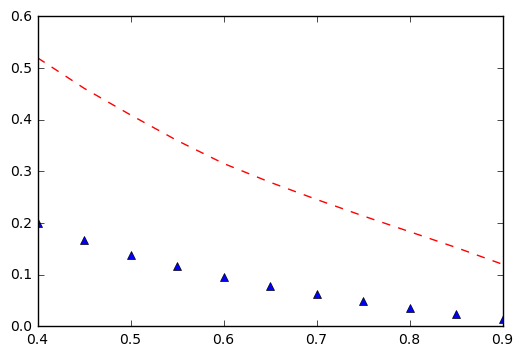

In [64]:
import matplotlib.pyplot as plt
plt.cla()
true_ratio = [0.] * 11
false_ratio = [0.] *11
THRESHOLD = [0.]*11
for i in range(11):
    THRESHOLD[i] = 0.4 + 0.05 * i
    result = batch_test(THRESHOLD[i])
    true_ratio[i] = result['threshold_ratio']
    false_ratio[i],totalCount = batch_false_test(THRESHOLD[i])
plt.plot(THRESHOLD, true_ratio, 'r--')
plt.plot(THRESHOLD, false_ratio, 'b^')
plt.show()

In [11]:
print true_ratio
print false_ratio

[0.6944206008583691, 0.6527420123986648, 0.6133524082021936, 0.5726275631855031, 0.5332379589890319, 0.49194086790653313, 0.44835479256080113, 0.4005722460658083, 0.3402956604673343]
[0.2395666131621188, 0.1902086677367576, 0.14446227929374, 0.1071428571428571, 0.0810593900481541, 0.050963081861958304, 0.0304975922953451, 0.016853932584269704, 0.008025682182985605]


In [16]:
print class_labels

{0: 'blueberry', 1: 'pitahaya', 2: 'rambutan', 3: 'avocado', 4: 'grapefruit', 5: 'pomegranate', 6: 'grape', 7: 'papaya', 8: 'watermelon', 9: 'coconut', 10: 'cantaloup', 11: 'apple', 12: 'pomelo', 13: 'carambola', 14: 'apricot', 15: 'peach', 16: 'cherry', 17: 'banana', 18: 'pineapple', 19: 'strawberry', 20: 'plum', 21: 'mango', 22: 'kiwi', 23: 'mulberry', 24: 'mangosteen', 25: 'litchi', 26: 'blackberry', 27: 'lemon', 28: 'orange', 29: 'raspberry', 30: 'loquat', 31: 'durian', 32: 'pear', 33: 'passion_fruit', 34: 'nectarine', 35: 'bayberry', 36: 'dogs', 37: 'leshi_photatochips_bag', 38: 'haoliyou_potatochips_barrel', 39: 'knife', 40: 'bed', 41: 'remote', 42: 'shaver', 43: 'waterbottle', 44: 'can', 45: 'cosmetic', 46: 'chair', 47: 'wineglass', 48: 'screen', 49: 'mouse', 50: 'hairdrier', 51: 'plate', 52: 'table', 53: 'airconditioner', 54: 'clockwatch', 55: 'sofa', 56: 'refridgerator', 57: 'key', 58: 'hammer', 59: 'keyboard', 60: 'person', 61: 'cars'}


In [1]:
 for i in result:
     accuracy = result[i]['correct'] * 1. / result[i]['total']
     print "{}: {}".format(class_labels[i], accuracy)

NameError: name 'result' is not defined

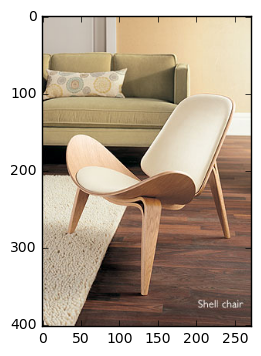

label: 46 , prediction: 39 , score of predict: 0.217513
0.217513
[ 0.000448    0.00055365  0.00062563  0.00458434  0.00236202  0.00076784
  0.00190836  0.00091956  0.00419509  0.02350044  0.01470984  0.00863282
  0.00039729  0.0005671   0.00105294  0.00228207  0.00180438  0.00803672
  0.00744561  0.00393046  0.00028018  0.00286126  0.00432942  0.00067836
  0.00055128  0.0049973   0.00040216  0.00112772  0.00377731  0.00293142
  0.00060235  0.02261291  0.01523768  0.00509124  0.00127018  0.00095321
  0.00877191  0.00191933  0.00410991  0.2175131   0.07501921  0.00186708
  0.03181908  0.00635944  0.00338     0.00360017  0.0758657   0.04934128
  0.03493077  0.00207095  0.01203993  0.00676855  0.09053819  0.017306
  0.0037029   0.08600988  0.009087    0.01610428  0.03197203  0.03927885
  0.0200923   0.00325207]


In [63]:
label, prediction, score,out = single_test(11431,True)
#out = out[0, 1].reshape(num_classes, 1)
#argmax_idx = out.argmax(axis=0)
print 'label:',label,', prediction:',prediction,', score of predict:',score
print out[prediction]
print out